In [2]:
import pytest
import deepchem as dc
import tempfile
import pandas as pd
import numpy as np
import os
print(os.getcwd())
from dataset_mpnn import get_dataset, get_class_imbalance_ratio
from deepchem.models.optimizers import ExponentialDecay
from datetime import datetime
from sklearn.metrics import roc_auc_score
from utils.splitter import iterative_train_test_split
import logging
import torch

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/ary2260/miniconda3/envs/odor_pom/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/ary2260/miniconda3/envs/odor_pom/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


/home/ary2260/Work/UK Research/odor-model-pipeline/MPNN


In [3]:
torch.manual_seed(1)
# load sample dataset
# dataset, _ = get_dataset(csv_path='assets/GS_LF_sample100.csv')
# dataset, _ = get_dataset(csv_path='./../curated_GS_LF_merged_4984.csv')
dataset, _ = get_dataset(csv_path='./../curated_GS_LF_merged_4983.csv')
# dataset, _ = get_dataset(csv_path='./../curated_GS_LF_merged_4983_L_priority.csv')
# dataset, _ = get_dataset(csv_path='./../curated_GS_LF_merged_4970_50_plus.csv')
# dataset, _ = get_dataset(csv_path='./../curated_GS_LF_merged_4948_75_plus.csv')
n_tasks = len(dataset.tasks)
#%%
# randomstratifiedsplitter = dc.splits.RandomStratifiedSplitter()
# train_dataset, test_dataset = randomstratifiedsplitter.train_test_split(dataset, frac_train = 0.8, seed = 1)
# train_dataset, test_dataset = iterative_train_test_split(dataset, test_size= 0.2, random_state=None, train_dir=None, test_dir=None)
# train_ratios = get_class_imbalance_ratio(pd.DataFrame(train_dataset.y))
# learning_rate = ExponentialDecay(initial_rate=0.01, decay_rate=0.5, decay_steps=3000, staircase=True)

# %%


number of odor tasks =  138


Failed to featurize datapoint 3408, O. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3413, [Cl-].[K+]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3581, [He]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3582, [Zn]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3601, O.O.O.O.O.O.[Cl-].[Cl-].[Co+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3614, [Cl-].[NH4+]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3615, [NH4+].[NH4+].[S-2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3715, [Mg+2].[OH-].[OH-]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 4445, [Ca+2].[OH-].[OH-]. Appending empt

In [4]:
learning_rate = 0.001
# initialize the model
from custom_mpnn import CustomMPNNModel
from featurizer import GraphConvConstants
from custom_mpnn import CustomMPNNModel
model = CustomMPNNModel(n_tasks = n_tasks,
                            batch_size=128,
                            learning_rate=learning_rate,
                            class_imbalance_ratio = [],
                            node_out_feats = 100,
                            edge_hidden_feats = 75,
                            edge_out_feats = 100,
                            num_step_message_passing = 5,
                            mode = 'classification',
                            number_atom_features = GraphConvConstants.ATOM_FDIM,
                            number_bond_features = GraphConvConstants.BOND_FDIM,
                            n_classes = 1,
                            num_step_set2set = 3,
                            num_layer_set2set = 2,
                            ffn_hidden_list= [392, 392],
                            ffn_embeddings = 256,
                            ffn_activation = 'relu',
                            ffn_dropout_p = 0.12,
                            ffn_dropout_at_input_no_act = False,
                            weight_decay = 1e-5,
                            self_loop = False,
                            log_frequency = 32,
                            model_dir = './models')

model.restore('./models/875_test_model.pt')

In [ ]:
pom_embeds = model.predict_embedding(dataset)

In [ ]:
pom_embeds.shape

(4972, 256)

In [ ]:
y_preds = model.predict(dataset)

In [ ]:
y_preds.shape

(4972, 138)

In [ ]:
y_preds[0]

array([0.17714696, 0.0090839 , 0.01560712, 0.02389987, 0.06052509,
       0.10342432, 0.01066645, 0.00386299, 0.00459169, 0.02974111,
       0.03339207, 0.0051627 , 0.07480081, 0.00615701, 0.02423375,
       0.04560727, 0.0119429 , 0.01061925, 0.06717089, 0.13773595,
       0.04004541, 0.11137644, 0.04496344, 0.02800906, 0.02996614,
       0.00182766, 0.3328179 , 0.0072836 , 0.12815931, 0.00494274,
       0.04395097, 0.07333869, 0.01028316, 0.09377171, 0.0602741 ,
       0.06618588, 0.01772808, 0.03983195, 0.12122703, 0.00331708,
       0.01913364, 0.10642192, 0.00208801, 0.09320974, 0.03266707,
       0.12648304, 0.1072217 , 0.1300154 , 0.18810426, 0.58599734,
       0.01963095, 0.04052122, 0.01162564, 0.03257062, 0.03414191,
       0.04159414, 0.00814801, 0.03508637, 0.01845716, 0.0451802 ,
       0.03321204, 0.02544541, 0.02494463, 0.05208033, 0.03246031,
       0.0300636 , 0.00456599, 0.0019254 , 0.02066186, 0.0397023 ,
       0.02148448, 0.00724207, 0.02192869, 0.028933  , 0.02456

In [ ]:
import numpy as np
k = np.where(y_preds>0.4, 1.0, 0.0)

In [ ]:
k.shape

(4972, 138)

In [ ]:
dataset.y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [ ]:
k[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import gaussian_kde
import numpy as np

def pom_frame(model, dataset, epoch, is_preds=False, threshold=0.4):
    pom_embeds = model.predict_embedding(dataset)
    y_preds = model.predict(dataset)
    required_desc = list(dataset.tasks)
    type1 = {'floral': '#F3F1F7', 'subs': {'muguet': '#FAD7E6', 'lavender': '#8883BE', 'jasmin': '#BD81B7'}}
    type2 = {'meaty': '#F5EBE8', 'subs': {'savory': '#FBB360', 'beefy': '#7B382A', 'roasted': '#F7A69E'}}
    type3 = {'ethereal': '#F2F6EC', 'subs': {'cognac': '#BCE2D2', 'fermented': '#79944F', 'alcoholic': '#C2DA8F'}}

    # Assuming you have your features in the 'features' array
    pca = PCA(n_components=2, iterated_power=10)  # You can choose the number of components you want (e.g., 2 for 2D visualization)
    reduced_features = pca.fit_transform(pom_embeds)

    variance_explained = pca.explained_variance_ratio_

    # Variance explained by PC1 and PC2
    variance_pc1 = variance_explained[0]
    variance_pc2 = variance_explained[1]

    if is_preds:
        y = np.where(y_preds>threshold, 1.0, 0.0)
    else:
        y = dataset.y

    # Generate grid points to evaluate the KDE on
    x_grid, y_grid = np.meshgrid(np.linspace(reduced_features[:, 0].min(), reduced_features[:, 0].max(), 500),
                                 np.linspace(reduced_features[:, 1].min(), reduced_features[:, 1].max(), 500))
    grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()])

    def get_kde_values(label):
        plot_idx = required_desc.index(label)
        label_indices = np.where(y[:, plot_idx] == 1)[0]
        if len(label_indices) == 0:
            raise Exception("invalid")
        kde_label = gaussian_kde(reduced_features[label_indices].T)
        kde_values_label = kde_label(grid_points)
        kde_values_label = kde_values_label.reshape(x_grid.shape)
        return kde_values_label
    
    def plot_contours(type_dictionary, bbox_to_anchor):
        main_label = list(type_dictionary.keys())[0]
        plt.contourf(x_grid, y_grid, get_kde_values(main_label), levels=1, colors=['#00000000',type_dictionary[main_label],type_dictionary[main_label]])
        legend_elements = []
        for label, color in type_dictionary['subs'].items():
            plt.contour(x_grid, y_grid, get_kde_values(label), levels=1, colors=color, linewidths=2)
            legend_elements.append(Patch(facecolor=color, label=label))
        legend = plt.legend(handles=legend_elements, title=main_label, bbox_to_anchor=bbox_to_anchor)
        legend.get_frame().set_facecolor(type_dictionary[main_label])
        plt.gca().add_artist(legend)

    plt.figure(figsize=(15, 10))
    plt.title('KDE Density Estimation with Contours in Reduced Space')
    plt.xlabel(f'Principal Component 1 ({round(variance_pc1*100, ndigits=2)}%)')
    plt.ylabel(f'Principal Component 2 ({round(variance_pc2*100, ndigits=2)}%)')
    plot_contours(type_dictionary=type1, bbox_to_anchor = (0.2, 0.8))
    plot_contours(type_dictionary=type2, bbox_to_anchor = (0.9, 0.4))
    plot_contours(type_dictionary=type3, bbox_to_anchor = (0.3, 0.1))
    # plt.colorbar(label='Density')
    plt.show()
    # plt.savefig(f'pom_frame_{epoch}')
    

In [ ]:
# from utils.pom_frame import pom_frame

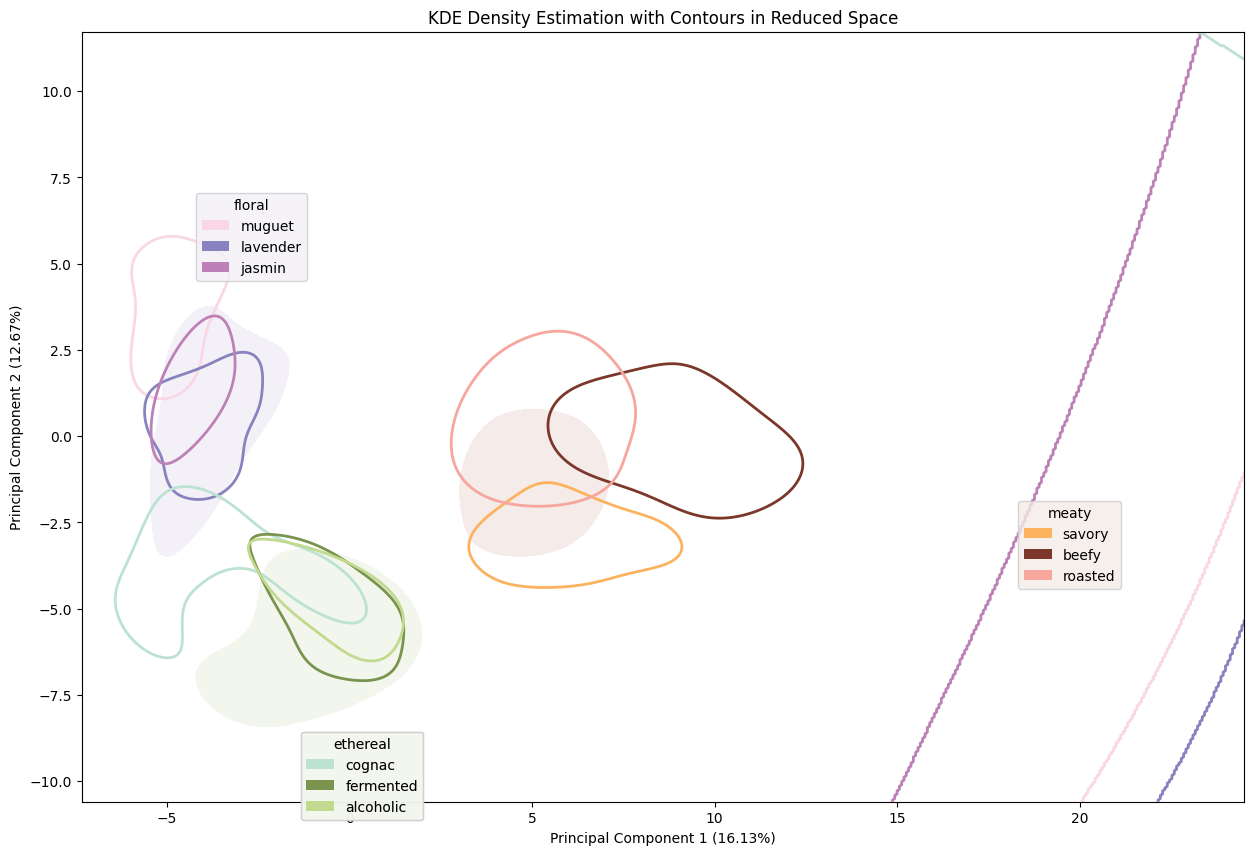

In [ ]:
pom_frame(model, dataset, 1, is_preds=True)

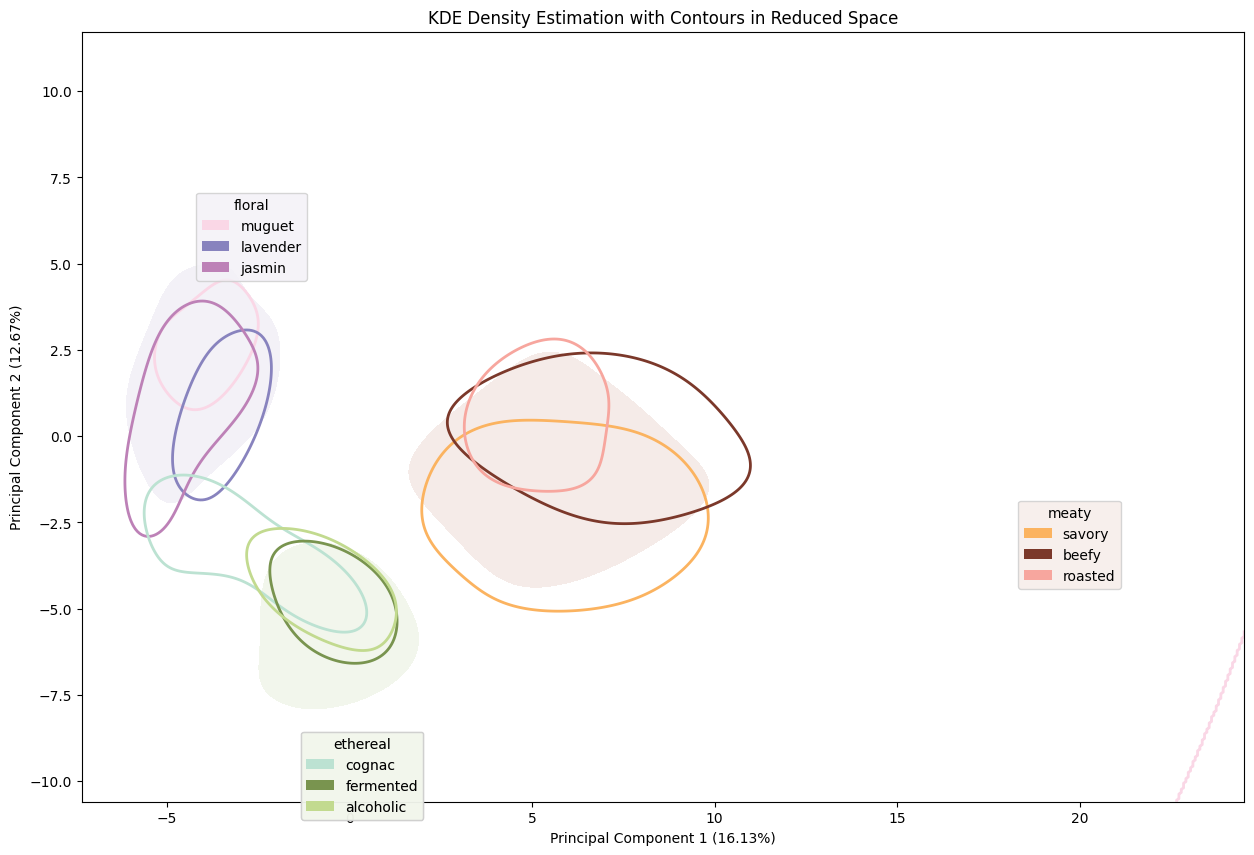

In [ ]:
pom_frame(model, dataset, 1, is_preds=False)

Model- and label-space comparisons

In [5]:
# from sklearn.decomposition import PCA
# pom_embeds = model.predict_embedding(dataset)
# # y_preds = model.predict(dataset)
# required_desc = list(dataset.tasks)
# y_true = dataset.y
    
# # Assuming you have your features in the 'features' array
# pca = PCA(n_components=2, iterated_power=10)  # You can choose the number of components you want (e.g., 2 for 2D visualization)
# reduced_features = pca.fit_transform(pom_embeds)


# pca = PCA(n_components=2, iterated_power=10)  # You can choose the number of components you want (e.g., 2 for 2D visualization)
# reduced_features_labels = pca.fit_transform(y_true)
# import numpy as np
# import itertools
# from sklearn.metrics.pairwise import euclidean_distances
# from datetime import datetime
# from tqdm import tqdm

# pairs_list = []
# for i in range(138):
#     for j in range(138):
#         if i==j:
#             continue
#         pairs_list.append((i,j))

# # embedding_inter_cluster_distances = []
# # for i, j in tqdm(pairs_list):
# #     start = datetime.now()
# #     label_indices_0 = np.where(y_true[:, i] == 1)[0]
# #     label_indices_1 = np.where(y_true[:, j] == 1)[0]
# #     cartesian_product = list(itertools.product(reduced_features[label_indices_0], reduced_features[label_indices_1]))
# #     distances = []
# #     for pair in cartesian_product:
# #         distances.append(euclidean_distances(pair)[0][1])
# #     embedding_inter_cluster_distances.append(np.asarray(distances).mean())
# #     end = datetime.now()
# #     # print(end-start)
# #%%
# import joblib

# embedding_inter_cluster_distances = {}
# def wrapper(i, j):
#     label_indices_0 = np.where(y_true[:, i] == 1)[0]
#     label_indices_1 = np.where(y_true[:, j] == 1)[0]
#     # cartesian_product = list(itertools.product(reduced_features[label_indices_0], reduced_features[label_indices_1]))
#     cartesian_product = list(itertools.product(reduced_features_labels[label_indices_0], reduced_features_labels[label_indices_1]))
#     distances = []
#     for pair in cartesian_product:
#         distances.append(euclidean_distances(pair)[0][1])
#     return {(i,j): np.asarray(distances).mean()}

# #%%
# results = joblib.Parallel(n_jobs=10)(
#     joblib.delayed(wrapper)(i, j)
#     for i, j in tqdm(pairs_list)
# )
# k = []
# for d in results:
#     k.append(list(d.values())[0])
# import pandas as pd
# df = pd.DataFrame(k)
# df.to_csv("LABELS_inter_cluster_distances.csv")
# x = pd.read_csv('embedding_inter_cluster_distances.csv')
# y = pd.read_csv('LABELS_inter_cluster_distances.csv')

# x['0'].info
# y['1'] = y['0']*5 - y['0'].min()*5
# df2 = pd.DataFrame({})
# df2['embed_ICD'] = x['0']
# df2['label_ICD'] = y['0']
# df2['label_ICD_transformed'] = y['1']
# df2.info()

# df2.to_csv('inter_cluster_distances.csv', index=False)

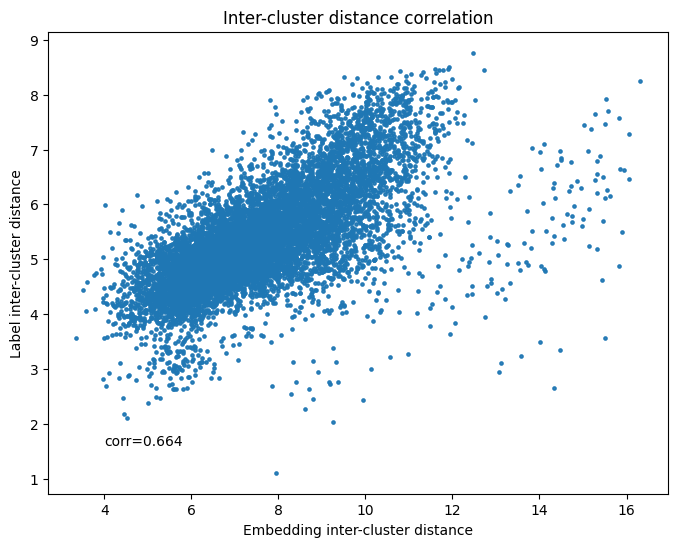

In [89]:
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('inter_cluster_distances.csv')
df['label_ICD_transformed'] = df['label_ICD']*5
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
plt.scatter(df['embed_ICD'], df['label_ICD_transformed'], color='#1F77B4', label='Dataset 1', s=5, alpha=0.7, edgecolors='#1F77B4')
# plt.hist(x['0'], bins=20)
# Add labels and title
plt.xlabel('Embedding inter-cluster distance')
plt.ylabel('Label inter-cluster distance')
plt.title('Inter-cluster distance correlation')

corr_matrix = np.corrcoef(df['embed_ICD'], df['label_ICD'])
corr_coefficient = round(corr_matrix[0, 1], ndigits=3)

# Add legend
plt.text(x=4, y=1.6, s=f'corr={corr_coefficient}')

# Show the plot
plt.show()

In [53]:
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances

pom_embeds = model.predict_embedding(dataset)
# y_preds = model.predict(dataset)
required_desc = list(dataset.tasks)
y_true = dataset.y
    
# Assuming you have your features in the 'features' array
pca = PCA(n_components=2, iterated_power=10)  # You can choose the number of components you want (e.g., 2 for 2D visualization)
reduced_features = pca.fit_transform(pom_embeds)


pca = PCA(n_components=2, iterated_power=10)  # You can choose the number of components you want (e.g., 2 for 2D visualization)
reduced_features_labels = pca.fit_transform(y_true)

# group_pairwise_distance_means = []
# for i in tqdm(range(138)):
#     label_indices = np.where(y_true[:, i] == 1)[0]
#     in_grp = reduced_features[label_indices]
#     print(in_grp)

#     pairs_list = []
#     for i in range(len(in_grp)):
#         for j in range(len(in_grp)):
#             if i==j:
#                 continue
#             pairs_list.append((i,j))

#     in_group_pairwise_distances = []
#     for i, j in pairs_list:
#         pair=(in_grp[i], in_grp[j])
#         distance = euclidean_distances(pair)[0][1]
#         in_group_pairwise_distances.append(distance)
    
#     group_pairwise_distance_means.append(np.asarray(in_group_pairwise_distances).mean())
# import joblib

# def wrapper(i):
#     label_indices = np.where(y_true[:, i] == 1)[0]
#     in_grp = reduced_features_labels[label_indices]

#     pairs_list = []
#     for i in range(len(in_grp)):
#         for j in range(len(in_grp)):
#             if i==j:
#                 continue
#             pairs_list.append((i,j))

#     in_group_pairwise_distances = []
#     for i, j in pairs_list:
#         pair=(in_grp[i], in_grp[j])
#         distance = euclidean_distances(pair)[0][1]
#         in_group_pairwise_distances.append(distance)
    
#     return np.asarray(in_group_pairwise_distances).mean()

# #%%
# results = joblib.Parallel(n_jobs=10)(
#     joblib.delayed(wrapper)(i)
#     for i in tqdm(range(138))
# )

# df = pd.DataFrame(results)
# df.to_csv('group_pairwise_distance_means_labels.csv')

import joblib

in_grp = reduced_features_labels
pairs_list = []
for i in range(len(in_grp)):
    for j in range(len(in_grp)):
        if i==j:
            continue
        pairs_list.append((i,j))

def wrapper(i, j):
    pair=(in_grp[i], in_grp[j])
    distance = euclidean_distances(pair)[0][1]
    return distance

#%%
results = joblib.Parallel(n_jobs=10)(
    joblib.delayed(wrapper)(i, j)
    for i, j in tqdm(pairs_list)
)

100%|██████████| 24715812/24715812 [05:03<00:00, 81332.81it/s] 


In [54]:
np.asarray(results).mean()

0.964731275024328

In [55]:
df1 = pd.read_csv('group_pairwise_distance_means_embeddings.csv')
df2 = pd.read_csv('group_pairwise_distance_means_labels.csv')

df_main = pd.DataFrame({})

mean1 = 7.857383 #calculated above
mean2 = 0.964731275024328

df_main['Cluster tightness embeddings'] = df1['0']/mean1
df_main['Cluster tightness labels'] = df2['0']/mean2

In [61]:
print(df_main['Cluster tightness embeddings'].quantile(0.5))
print(df_main['Cluster tightness labels'].quantile(0.5))

0.7082873776166951
0.8857309629895241


In [56]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Cluster tightness embeddings  138 non-null    float64
 1   Cluster tightness labels      138 non-null    float64
dtypes: float64(2)
memory usage: 2.3 KB


In [57]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Create a list of data to plot
data_to_plot = [df_main['Cluster tightness embeddings'], df_main['Cluster tightness labels']]
df_temp = pd.DataFrame()
df_temp['Cluster tightness'] = df_main['Cluster tightness embeddings']
df_temp['Type'] = df_temp['Cluster tightness'].apply(lambda x: 'gnn')

df_temp2 = pd.DataFrame()
df_temp2['Cluster tightness'] = df_main['Cluster tightness labels']
df_temp2['Type'] = df_temp2['Cluster tightness'].apply(lambda x: 'label')
df_merged = pd.concat([df_temp, df_temp2], ignore_index=True)


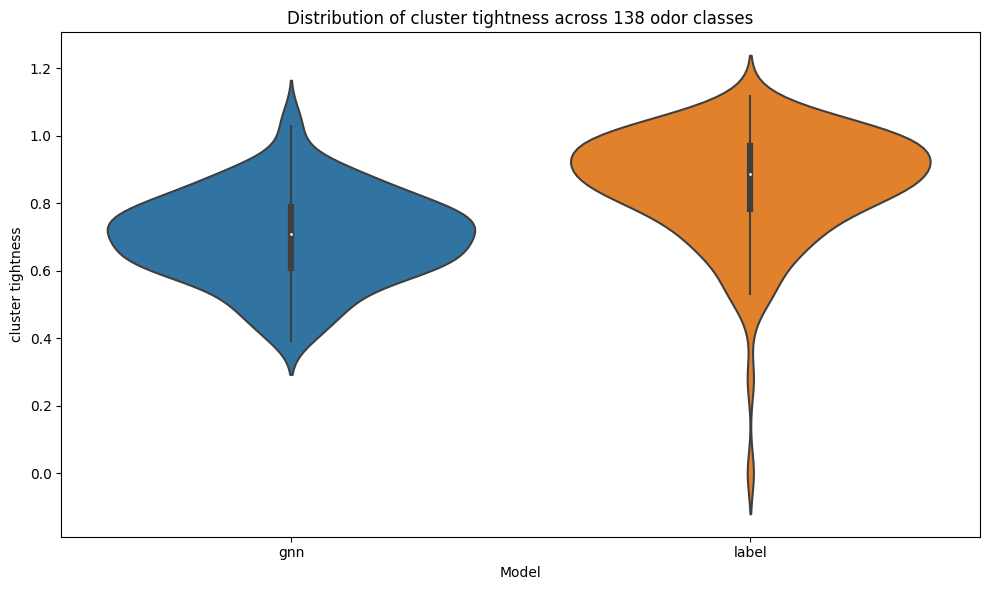

In [58]:

# Create a figure and axis
plt.figure(figsize=(10, 6))
ax = plt.subplot()

# Plot the first violin plot
sns.violinplot(x='Type', y='Cluster tightness', data=df_merged)

# Plot the second violin plot
# sns.violinplot(y='Cluster tightness labels', data=df_main, ax=ax, inner="quartile", palette="Set2")

# Set labels and title
plt.xlabel("Model")
plt.ylabel("cluster tightness")
plt.title("Distribution of cluster tightness across 138 odor classes")

# Show the plot
plt.tight_layout()
plt.show()

In [63]:
y_test = dataset.y
y_pred_probabilities = model.predict(dataset)
auc_roc_scores = []
for i in range(138):
    auc_roc_scores.append(roc_auc_score(y_test[:, i], y_pred_probabilities[:, i]))

In [64]:
auc_roc_scores_paper = [0.961,
 0.961,
 0.967,
 0.943,
 0.931,
 0.812,
 0.791,
 0.917,
 0.93,
 0.855,
 0.91,
 0.961,
 0.976,
 0.959,
 0.858,
 0.719,
 0.984,
 0.982,
 0.903,
 0.881,
 0.977,
 0.951,
 0.904,
 0.969,
 0.878,
 0.956,
 0.92,
 0.905,
 0.925,
 0.88,
 0.918,
 0.878,
 0.947,
 0.938,
 0.959,
 0.938,
 0.979,
 0.848,
 0.973,
 0.759,
 0.95,
 0.808,
 0.983,
 0.884,
 0.731,
 0.745,
 0.915,
 0.898,
 0.895,
 0.915,
 0.852,
 0.756,
 0.84,
 0.859,
 0.986,
 0.986,
 0.905,
 0.953,
 0.929,
 0.845,
 0.818,
 0.942,
 0.775,
 0.987,
 0.766,
 0.872,
 0.943,
 0.951,
 0.907,
 0.966,
 0.919,
 0.961,
 0.842,
 0.83,
 0.855,
 0.937,
 0.888,
 0.945,
 0.906,
 0.884,
 0.758,
 0.849,
 0.898,
 0.922,
 0.91,
 0.917,
 0.774,
 0.811,
 0.844,
 0.973,
 0.833,
 0.979,
 0.933,
 0.973,
 0.91,
 0.957,
 0.839,
 0.952,
 0.949,
 0.956,
 0.954,
 0.862,
 0.977,
 0.983,
 0.881,
 0.886,
 0.923,
 0.827,
 0.911,
 0.932,
 0.92,
 0.812,
 0.963,
 0.944,
 0.81,
 0.909,
 0.885,
 0.857,
 0.839,
 0.813,
 0.909,
 0.983,
 0.914,
 0.747,
 0.745,
 0.995,
 0.877,
 0.941,
 0.848,
 0.985,
 0.884,
 0.907,
 0.833,
 0.815,
 0.902,
 0.748,
 0.902,
 0.873]

In [120]:
df = pd.DataFrame({'test_model':auc_roc_scores, 'paper_model': auc_roc_scores_paper})

In [121]:
df['diff'] = df.apply(lambda x: x.test_model - x.paper_model, axis=1)

In [122]:
df['type'] = required_desc

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   test_model   138 non-null    float64
 1   paper_model  138 non-null    float64
 2   diff         138 non-null    float64
 3   type         138 non-null    object 
dtypes: float64(3), object(1)
memory usage: 4.4+ KB


In [124]:
df.head()

,test_model,paper_model,diff,type
0,0.981710,0.961,0.020710,alcoholic
1,0.937286,0.961,-0.023714,aldehydic
2,0.977522,0.967,0.010522,alliaceous
3,0.931234,0.943,-0.011766,almond
4,0.933957,0.931,0.002957,amber


In [125]:
df = df.sort_values(by='diff')
df.head()

,test_model,paper_model,diff,type
57,0.881393,0.953,-0.071607,grape
16,0.924283,0.984,-0.059717,black currant
38,0.921312,0.973,-0.051688,cooling
17,0.940558,0.982,-0.041442,brandy
71,0.927243,0.961,-0.033757,lavender


In [128]:
df[df['diff']>0]

,test_model,paper_model,diff,type
54,0.986908,0.986,0.000908,garlic
99,0.957297,0.956,0.001297,pine
75,0.938538,0.937,0.001538,lily
69,0.967904,0.966,0.001904,ketonic
91,0.981042,0.979,0.002042,onion
...,...,...,...,...
39,0.875004,0.759,0.116004,cortex
45,0.863893,0.745,0.118893,earthy
6,0.910886,0.791,0.119886,anisic
132,0.955701,0.833,0.122701,violet


In [137]:
print(len(df[df['diff']>0]))
print(len(df[df['diff']<-0.01]))

96
25


In [138]:
df[df['diff']<-0.01]

,test_model,paper_model,diff,type
57,0.881393,0.953,-0.071607,grape
16,0.924283,0.984,-0.059717,black currant
38,0.921312,0.973,-0.051688,cooling
17,0.940558,0.982,-0.041442,brandy
71,0.927243,0.961,-0.033757,lavender
63,0.960014,0.987,-0.026986,hazelnut
103,0.956432,0.983,-0.026568,potato
129,0.959990,0.985,-0.025010,vanilla
122,0.889281,0.914,-0.024719,sweaty
1,0.937286,0.961,-0.023714,aldehydic
